<a href="https://colab.research.google.com/github/CristianCosci/AGV-Project/blob/gradcam_operations/AGV_emotions_attack/attacks_emotions/notebooks/grad_cam_mask_operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TODO**:
- [x] Generare una soglia basata sul Q'esimo percentile, ad esempio conserva solo il 20% dei pixel con i valori più alti, quindi genera una maschera binaria con questa soglia.
- [x] THRESH_BINARY
- [x] otsu
- [x] threshold fisso
- [x] THRESH_TOZERO
- [x] THRESH_TRUNC
- [x] prendere in modo random
- [x] prendere in modo random in base all'intensità (roulette wheel?)
- [ ] applicare il filtro in base all'intensità del valore in grayscale
- [ ] cosa succede se moltiplico la maschera (non grayscale) per l'immagine RGB

Documentazione: https://docs.opencv.org/4.x/d7/d1b/group__imgproc__misc.html#ggaa9e58d2860d4afa658ef70a9b1115576a147222a96556ebc1d948b372bcd7ac59

In [ ]:
!git clone -b grayscale_cam_tutorial https://github.com/CristianCosci/pytorch-grad-cam.git
!pip install grad-cam

import os
os.chdir('/content/pytorch-grad-cam/tutorials/')

In [27]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [28]:
import argparse
import cv2
import numpy as np
import torch
from torchvision import models
from pytorch_grad_cam import GradCAM,HiResCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad, \
    GradCAMElementWise
    

from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import matplotlib.pyplot as plt

In [29]:
MODEL_gradcam = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
TARGET_LAYERS = [MODEL_gradcam.layer4]

In [ ]:
rgb_img = cv2.imread('/content/gdrive/MyDrive/ILSVRC2012_img_val_labeled_caffe_200/57.6.JPEG', 1)[:, :, ::-1]
origin_img = cv2.imread('/content/gdrive/MyDrive/ILSVRC2012_img_val_labeled_caffe_200/57.6.JPEG', 1)

plt.imshow(rgb_img);

In [ ]:
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

cam_algorithm = GradCAM

with cam_algorithm(model = MODEL_gradcam, target_layers = TARGET_LAYERS) as cam:
  cam.batch_size = 32
  grayscale_cam = cam(input_tensor=input_tensor, targets=None)

  # Here grayscale_cam has only one image in the batch
  grayscale_cam = grayscale_cam[0, :]
  grayscale_cam_mask = grayscale_cam * 255  #make range between 0-255

plt.imshow(grayscale_cam_mask, cmap='gray')

**HIST CALCULATION FOR BETTER ANALISYS**

In [ ]:
plt.figure(figsize = [13, 8])
plt.hist(grayscale_cam_mask.ravel(),256,[0,256])
plt.show()

# **Threshold value based on  Q'th percentile**

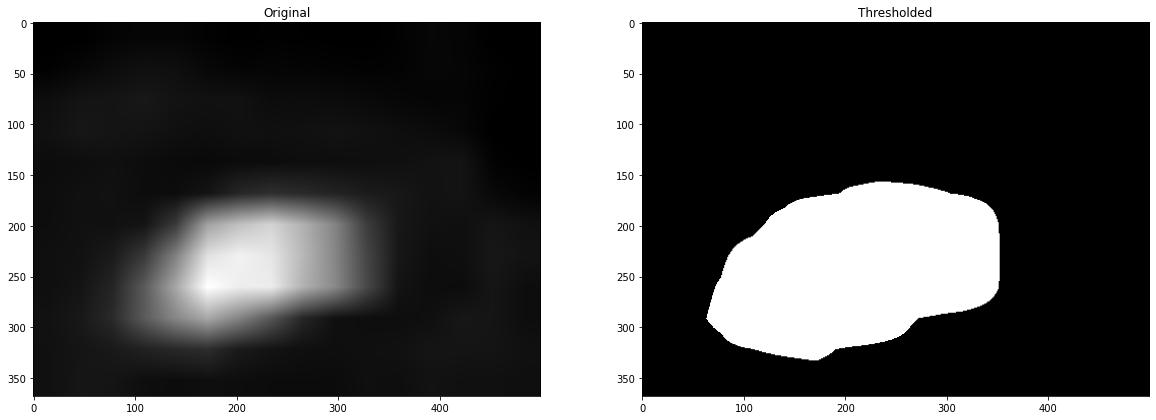

In [109]:
Q_th_percentile = 80
thresh_value = np.percentile(grayscale_cam_mask, Q_th_percentile)

_ , img_thresh = cv2.threshold(grayscale_cam_mask, thresh_value, 255, cv2.THRESH_BINARY)
mask = img_thresh.astype(np.uint8) #convert to uint8 for use in bitwise_and

# Display the images.
plt.figure(figsize = [20, 8])
plt.subplot(121); plt.imshow(grayscale_cam_mask, cmap='gray'); plt.title('Original')
plt.subplot(122); plt.imshow(img_thresh, cmap='gray'); plt.title('Thresholded');

### **If you want to get also indexes**

In [111]:
# Q_th_percentile = 80

# Flatten images and define flatten indeces
img_flat = grayscale_cam_mask.ravel()
indices = np.arange(len(img_flat))

# This results is a list of tuples, the first item of which is the original index and second of which is the value
list_with_indexes = sorted(enumerate(img_flat), key=lambda i: i[1])

array_with_indexes = np.array(list_with_indexes)

thresh_value = np.percentile(array_with_indexes[:, 1], Q_th_percentile)

counter = (array_with_indexes[:, 1] > thresh_value).sum()
print("Number of pixels in the ", Q_th_percentile, " :", counter)
print("In order to confirm that, number of pixels with value greater than ", thresh_value, " :", grayscale_cam_mask.size - grayscale_cam_mask.size/100*Q_th_percentile)

start_index = int(grayscale_cam_mask.size/100*Q_th_percentile)
selected_indexes =  np.array(array_with_indexes[start_index: , 0], dtype=int)

selected_pixels = np.column_stack(np.unravel_index(selected_indexes, shape=grayscale_cam_mask.shape))

Number of pixels in the  80  : 36800
In order to confirm that, number of pixels with value greater than  33.6244140625  : 36800.0


# **Threshold THRESH_BINARY**

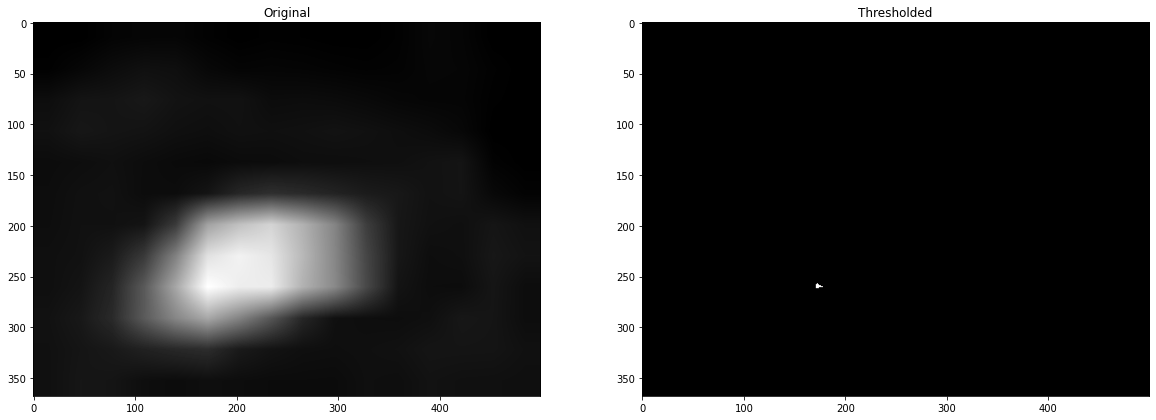

In [15]:
thresh_value = 155
_ , img_thresh = cv2.threshold(grayscale_cam_mask, thresh_value, 255, cv2.THRESH_BINARY)
mask = img_thresh.astype(np.uint8) #convert to uint8 for use in bitwise_and

# Display the images.
plt.figure(figsize = [20, 8])
plt.subplot(121); plt.imshow(grayscale_cam_mask, cmap='gray'); plt.title('Original')
plt.subplot(122); plt.imshow(img_thresh, cmap='gray'); plt.title('Thresholded');

# **Threshold adattivo**

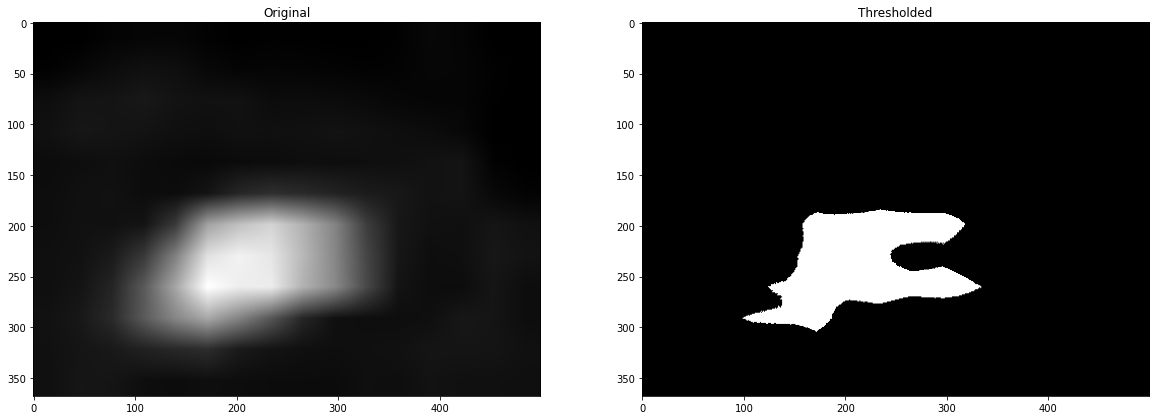

In [ ]:
grayscale_cam = np.around(grayscale_cam_mask).astype(np.uint8)
img_thresh = cv2.adaptiveThreshold(src=grayscale_cam, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C, thresholdType=cv2.THRESH_BINARY, blockSize=71, C=-11)

mask = img_thresh.astype(np.uint8) #convert to uint8 for use in bitwise_and

# Display the images.
plt.figure(figsize = [20, 8])
plt.subplot(121); plt.imshow(grayscale_cam_mask, cmap='gray'); plt.title('Original')
plt.subplot(122); plt.imshow(img_thresh, cmap='gray'); plt.title('Thresholded');

# **Threshold OTSU**

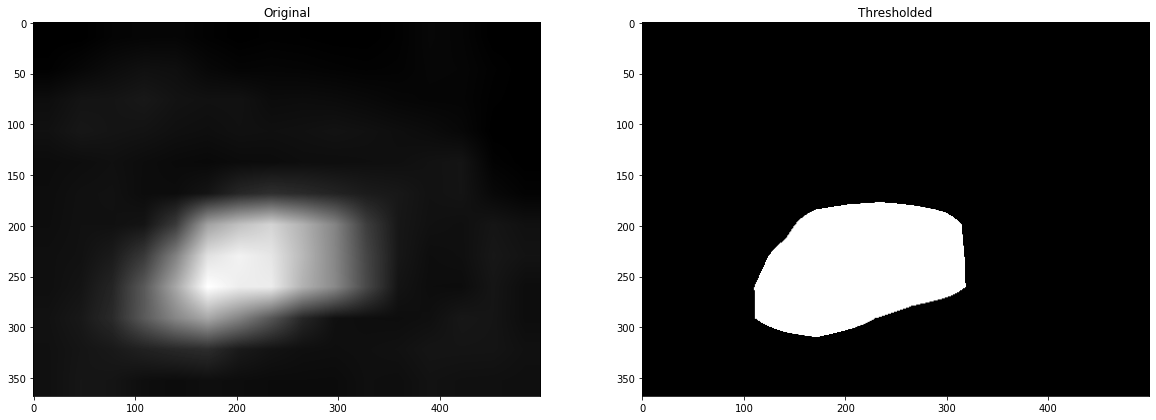

In [ ]:
grayscale_cam = np.around(grayscale_cam_mask).astype(np.uint8)

_ , img_thresh = cv2.threshold(grayscale_cam, 155, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
mask = img_thresh.astype(np.uint8) #convert to uint8 for use in bitwise_and

# Display the images.
plt.figure(figsize = [20, 8])
plt.subplot(121); plt.imshow(grayscale_cam_mask, cmap='gray'); plt.title('Original')
plt.subplot(122); plt.imshow(img_thresh, cmap='gray'); plt.title('Thresholded');

# **Threshold THRESH_TRUNC**

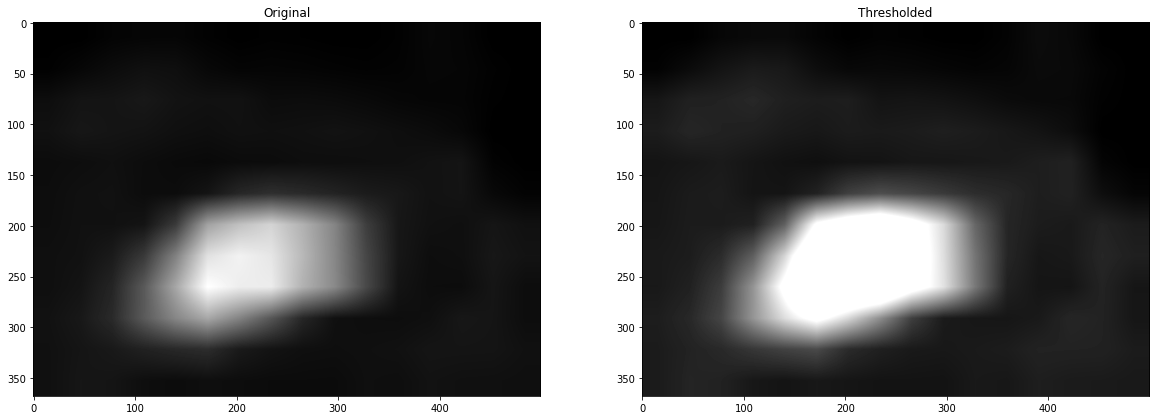

In [ ]:
_ , img_thresh = cv2.threshold(grayscale_cam_mask, 155, 255, cv2.THRESH_TRUNC)
mask = img_thresh.astype(np.uint8) #convert to uint8 for use in bitwise_and

# Display the images.
plt.figure(figsize = [20, 8])
plt.subplot(121); plt.imshow(grayscale_cam_mask, cmap='gray'); plt.title('Original')
plt.subplot(122); plt.imshow(img_thresh, cmap='gray'); plt.title('Thresholded');

# **Threshold THRESH_TOZERO**

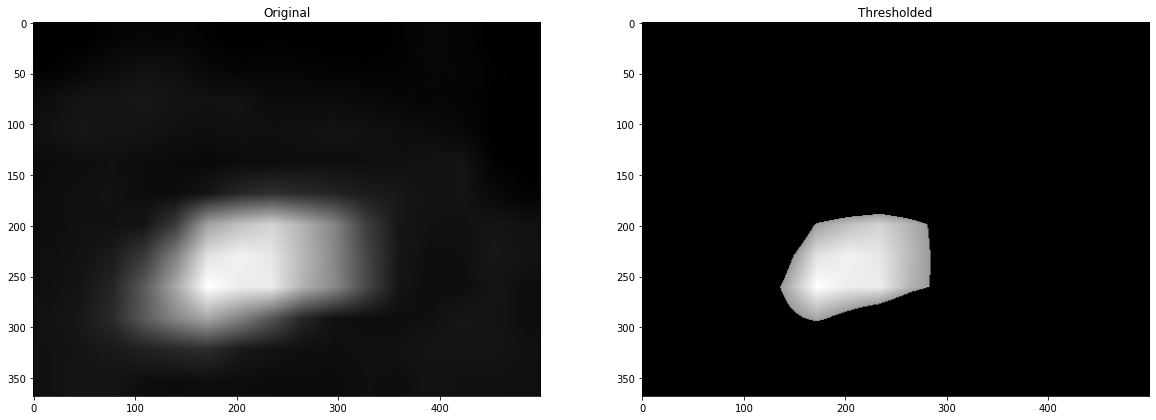

In [ ]:
_ , img_thresh = cv2.threshold(grayscale_cam_mask, 155, 200, cv2.THRESH_TOZERO)
mask = img_thresh.astype(np.uint8) #convert to uint8 for use in bitwise_and

# Display the images.
plt.figure(figsize = [20, 8])
plt.subplot(121); plt.imshow(grayscale_cam_mask, cmap='gray'); plt.title('Original')
plt.subplot(122); plt.imshow(img_thresh, cmap='gray'); plt.title('Thresholded');

# **Prove per migliorare applicazioni con scelte probabilistiche**

## **Uso di THRESH_BINARY e scelta probabilistica su esso**

In [ ]:
from sklearn.preprocessing import normalize

def get_probabilistic_mask(grayscale_cam_mask, thresh_value, pct, method=cv2.THRESH_BINARY):
  '''
    Create a mask choosing probabilistically pixels from img_thresh with a percentage pct.
    
    params:
      - grayscale_cam_mask: grayscale image computed by grad_cam
      - thresh_value: value for THRESH_TOZERO threshold
      - pct: percentage of pixels to get (from the ones with value 255) for probabilistic mask
    
    returns:
      - new_mask: new img with selected pixels
  '''
  # Apply threshold
  _ , img_thresh = cv2.threshold(grayscale_cam_mask, thresh_value, 255, method) 
  mask = img_thresh.astype(np.uint8) #convert to uint8 for use in bitwise_and

  # Number of pixels to choose based on percentage value
  num_pixels = int(np.count_nonzero(mask > 0) / 100 * pct)

  # Define a new mask with zero value for all pixels
  new_mask = np.zeros(mask.shape)

  # Flatten images and define flatten indeces
  img_flat = mask.ravel()
  indices = np.arange(len(img_flat))

  # Normalize probability to sum 1 in order to choose only between pixels with value of 255
  normalized_prob = normalize(mask.ravel().reshape(1, -1), axis=1, norm='l1').ravel()

  # Random sample
  selected_pixels = np.column_stack(np.unravel_index(np.random.choice(indices, size=num_pixels, replace=False, p = normalized_prob), 
                                                     shape=mask.shape))
  
  # Apply in new mask the selected pixels
  for pixel in selected_pixels:
    new_mask[pixel[0], pixel[1]] = 255
  
  return new_mask

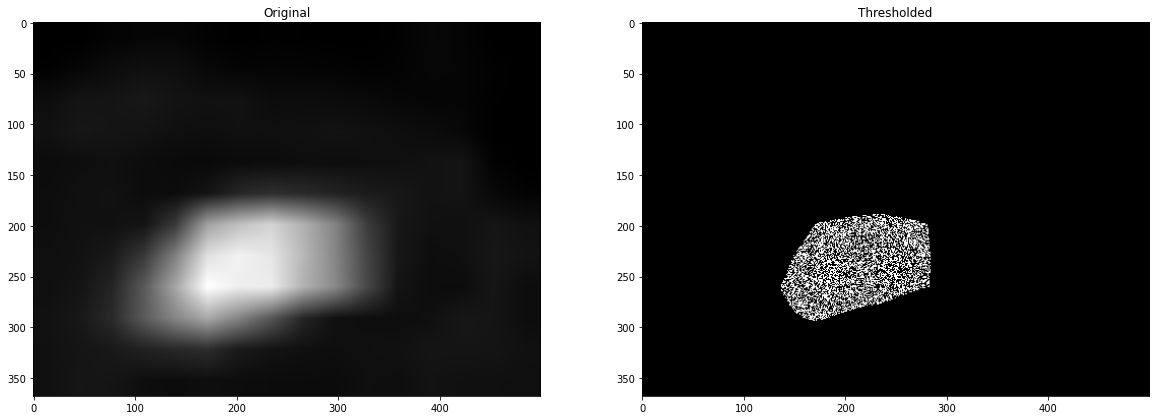

In [ ]:
mask = get_probabilistic_mask(grayscale_cam_mask, thresh_value=155, pct=50)
mask = mask.astype(np.uint8) #convert to uint8 for use in bitwise_and

# Display the images.
plt.figure(figsize = [20, 8])
plt.subplot(121); plt.imshow(grayscale_cam_mask, cmap='gray'); plt.title('Original')
plt.subplot(122); plt.imshow(mask, cmap='gray'); plt.title('Thresholded');

## **Uso di THRESH_TOZERO e scelta probabilistica su esso basata su roulette wheel**

In [ ]:
from sklearn.preprocessing import normalize

def get_probabilistic_mask(grayscale_cam_mask, thresh_value, pct, method=cv2.THRESH_BINARY):
  '''
    Create a mask choosing probabilistically pixels from img_thresh with a percentage pct.
    
    params:
      - grayscale_cam_mask: grayscale image computed by grad_cam
      - thresh_value: value for THRESH_TOZERO threshold
      - pct: percentage of pixels to get (from the ones with value 255) for probabilistic mask
    
    returns:
      - new_mask: new img with selected pixels
  '''
  # Apply threshold
  _ , img_thresh = cv2.threshold(grayscale_cam_mask, thresh_value, 255, method) 
  mask = img_thresh.astype(np.uint8) #convert to uint8 for use in bitwise_and

  # Number of pixels to choose based on percentage value
  num_pixels = int(np.count_nonzero(mask > 0) / 100 * pct)

  # Define a new mask with zero value for all pixels
  new_mask = np.zeros(mask.shape)

  # Flatten images and define flatten indeces
  img_flat = mask.ravel()
  indices = np.arange(len(img_flat))

  # Normalize probability to sum 1 in order to choose only between pixels with value of 255
  normalized_prob = normalize(mask.ravel().reshape(1, -1), axis=1, norm='l1').ravel()

  # Random sample
  selected_pixels = np.column_stack(np.unravel_index(np.random.choice(indices, size=num_pixels, replace=False, p = normalized_prob), 
                                                     shape=mask.shape))
  
  # Apply in new mask the selected pixels
  for pixel in selected_pixels:
    new_mask[pixel[0], pixel[1]] = 255
  
  return new_mask

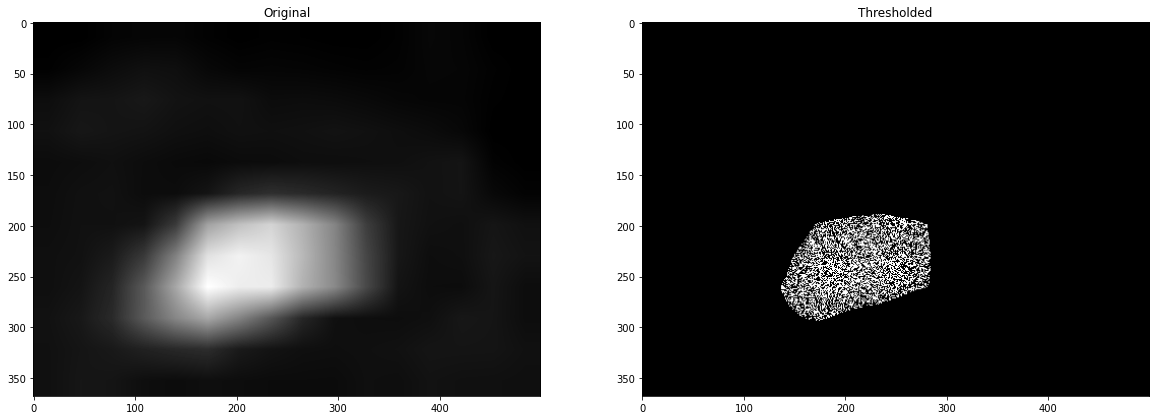

In [ ]:
mask = get_probabilistic_mask(grayscale_cam_mask, thresh_value=155, pct=50, method=cv2.THRESH_TOZERO)
mask = mask.astype(np.uint8) #convert to uint8 for use in bitwise_and

# Display the images.
plt.figure(figsize = [20, 8])
plt.subplot(121); plt.imshow(grayscale_cam_mask, cmap='gray'); plt.title('Original')
plt.subplot(122); plt.imshow(mask, cmap='gray'); plt.title('Thresholded');

# Altre operazioni

### **Isolating the img area using mask**

(368, 500, 3)


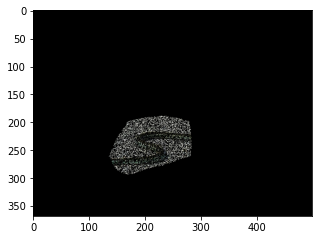

In [ ]:
img_applied_mask = cv2.bitwise_and(rgb_img, rgb_img, mask = mask)

# Print the image shape.
print(img_applied_mask.shape);

# Display the image.
plt.figure(figsize = [5, 5])
plt.imshow(img_applied_mask);

### **Create an example of a filter to see the applications of created mask**

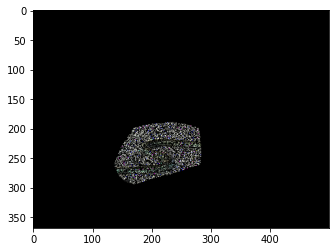

In [ ]:
matrix = np.ones(img_applied_mask.shape) * 1.5
filtered_img = np.uint8(cv2.multiply(np.float64(img_applied_mask * 255), matrix))

plt.imshow(filtered_img);

### **Create an inverse mask.**

(368, 500)


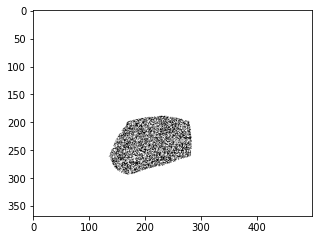

In [ ]:
img_logo_mask_inv = cv2.bitwise_not(mask)

# Print the image shape.
print(img_logo_mask_inv.shape)

# Display the image.
plt.figure(figsize = [5, 5])
plt.imshow(img_logo_mask_inv, cmap='gray');

###**Isolate the foreground using the inverse mask.**

(368, 500, 3)


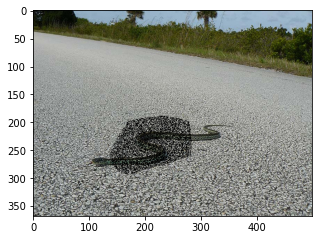

In [ ]:
img_foreground = cv2.bitwise_and(origin_img, origin_img, mask = img_logo_mask_inv)

# Print the image shape.
print(img_foreground.shape)

# Display the image.
plt.figure(figsize = [5, 5])
plt.imshow(img_foreground[:, :, ::-1]);

In [ ]:
img_foreground.dtype

dtype('uint8')

### **Add the two previous results to obtain the final result.**

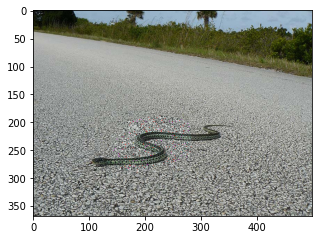

In [ ]:
result = cv2.add(filtered_img,img_foreground)

# Display the image and save the the result to the file system.
plt.figure(figsize = [5, 5])
plt.imshow(result[:, :, ::-1])
# cv2.imwrite('logo_final.png', result);